##### Copyright 2021 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Federated Reconstruction for Matrix Factorization

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/federated/tutorials/federated_reconstruction_for_matrix_factorization"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/federated/blob/v0.88.0/docs/tutorials/federated_reconstruction_for_matrix_factorization.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/federated/blob/v0.88.0/docs/tutorials/federated_reconstruction_for_matrix_factorization.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/federated/docs/tutorials/federated_reconstruction_for_matrix_factorization.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial explores *partially local federated learning*, where some client parameters are never aggregated on the server. This is useful for models with user-specific parameters (e.g. matrix factorization models) and for training in communication-limited settings. We build on concepts introduced in the [Federated Learning for Image Classification](https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification) tutorial; as in that tutorial, we introduce high-level APIs in `tff.learning` for federated training and evaluation.

We begin by motivating partially local federated learning for [matrix factorization](https://en.wikipedia.org/wiki/Matrix_factorization_(recommender_systems)). We describe Federated Reconstruction ([paper](https://arxiv.org/abs/2102.03448), [blog post](https://ai.googleblog.com/2021/12/a-scalable-approach-for-partially-local.html)), a practical algorithm for partially local federated learning at scale. We prepare the MovieLens 1M dataset, build a partially local model, and train and evaluate it.

In [ ]:
#@test {"skip": true}
!pip install --quiet --upgrade tensorflow-federated
!pip install --quiet --upgrade nest-asyncio

import nest_asyncio
nest_asyncio.apply()

In [1]:
import collections
import functools
import io
import os
import requests
import zipfile
from typing import List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff

np.random.seed(42)

## Background: Matrix Factorization

[Matrix factorization](https://en.wikipedia.org/wiki/Matrix_factorization_(recommender_systems)) has been a historically popular technique for learning recommendations and embedding representations for items based on user interactions. The canonical example is movie recommendation, where there are $n$ users and $m$ movies, and users have rated some movies. Given a user, we use their rating history and the ratings of similar users to predict the user's ratings for movies they haven't seen. If we have a model that can predict ratings, it's easy to recommend users new movies that they'll enjoy.

For this task, it's useful to represent users' ratings as an $n \times m$ matrix $R$:

![Matrix Factorization Motivation (CC BY-SA 3.0; Wikipedia User Moshanin)](https://upload.wikimedia.org/wikipedia/commons/5/52/Collaborative_filtering.gif)

This matrix is generally sparse, since users typically only see a small fraction of the movies in the dataset. The output of matrix factorization is two matrices: an $n \times k$ matrix $U$ representing $k$-dimensional user embeddings for each user, and an $m \times k$ matrix $I$ representing $k$-dimensional item embeddings for each item. The simplest training objective is to ensure that the dot product of user and item embeddings are predictive of observed ratings $O$:

$$argmin_{U,I}  \sum_{(u, i) \in O} (R_{ui} - U_u I_i^T)^2$$

This is equivalent to minimizing the mean squared error between observed ratings and ratings predicted by taking the dot product of the corresponding user and item embeddings. Another way to interpret this is that this ensures that $R \approx UI^T$ for known ratings, hence "matrix factorization". If this is confusing, don't worry–we won't need to know the details of matrix factorization for the rest of the tutorial.

## Exploring MovieLens Data

Let's start by loading the [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/) data, which consists of 1,000,209 movie ratings from 6040 users on 3706 movies.

In [2]:
def download_movielens_data(dataset_path):
  """Downloads and copies MovieLens data to local /tmp directory."""
  if dataset_path.startswith('http'):
    r = requests.get(dataset_path)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path='/tmp')
  else:
    tf.io.gfile.makedirs('/tmp/ml-1m/')
    for filename in ['ratings.dat', 'movies.dat', 'users.dat']:
      tf.io.gfile.copy(
          os.path.join(dataset_path, filename),
          os.path.join('/tmp/ml-1m/', filename),
          overwrite=True)

download_movielens_data('http://files.grouplens.org/datasets/movielens/ml-1m.zip')

In [3]:
def load_movielens_data(
    data_directory: str = "/tmp",
) -> Tuple[pd.DataFrame, pd.DataFrame]:
  """Loads pandas DataFrames for ratings, movies, users from data directory."""
  # Load pandas DataFrames from data directory. Assuming data is formatted as
  # specified in http://files.grouplens.org/datasets/movielens/ml-1m-README.txt.
  ratings_df = pd.read_csv(
      os.path.join(data_directory, "ml-1m", "ratings.dat"),
      sep="::",
      names=["UserID", "MovieID", "Rating", "Timestamp"], engine="python")
  movies_df = pd.read_csv(
      os.path.join(data_directory, "ml-1m", "movies.dat"),
      sep="::",
      names=["MovieID", "Title", "Genres"], engine="python", 
      encoding = "ISO-8859-1")

  # Create dictionaries mapping from old IDs to new (remapped) IDs for both
  # MovieID and UserID. Use the movies and users present in ratings_df to
  # determine the mapping, since movies and users without ratings are unneeded.
  movie_mapping = {
      old_movie: new_movie for new_movie, old_movie in enumerate(
          ratings_df.MovieID.astype("category").cat.categories)
  }
  user_mapping = {
      old_user: new_user for new_user, old_user in enumerate(
          ratings_df.UserID.astype("category").cat.categories)
  }

  # Map each DataFrame consistently using the now-fixed mapping.
  ratings_df.MovieID = ratings_df.MovieID.map(movie_mapping)
  ratings_df.UserID = ratings_df.UserID.map(user_mapping)
  movies_df.MovieID = movies_df.MovieID.map(movie_mapping)

  # Remove nulls resulting from some movies being in movies_df but not
  # ratings_df.
  movies_df = movies_df[pd.notnull(movies_df.MovieID)]

  return ratings_df, movies_df

Let's load and explore a couple Pandas DataFrames containing the rating and movie data.

In [4]:
ratings_df, movies_df = load_movielens_data()

We can see that each rating example has a rating from 1-5, a corresponding UserID, a corresponding MovieID, and a timestamp.

In [5]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,0,1104,5,978300760
1,0,639,3,978302109
2,0,853,3,978301968
3,0,3177,4,978300275
4,0,2162,5,978824291


Each movie has a title and potentially multiple genres.

In [6]:
movies_df.head()

,MovieID,Title,Genres
0,0.0,Toy Story (1995),Animation|Children's|Comedy
1,1.0,Jumanji (1995),Adventure|Children's|Fantasy
2,2.0,Grumpier Old Men (1995),Comedy|Romance
3,3.0,Waiting to Exhale (1995),Comedy|Drama
4,4.0,Father of the Bride Part II (1995),Comedy


It's always a good idea to understand basic statistics of the dataset:

In [7]:
print('Num users:', len(set(ratings_df.UserID)))
print('Num movies:', len(set(ratings_df.MovieID)))

Num users: 6040
Num movies: 3706


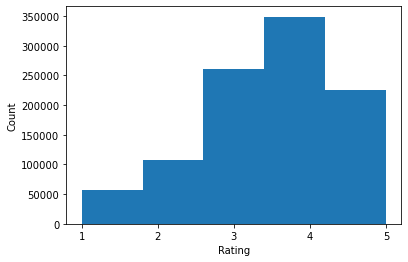

Average rating: 3.581564453029317
Median rating: 4.0


In [8]:
ratings = ratings_df.Rating.tolist()

plt.hist(ratings, bins=5)
plt.xticks([1, 2, 3, 4, 5])
plt.ylabel('Count')
plt.xlabel('Rating')
plt.show()

print('Average rating:', np.mean(ratings))
print('Median rating:', np.median(ratings))

We can also plot the most popular movie genres.

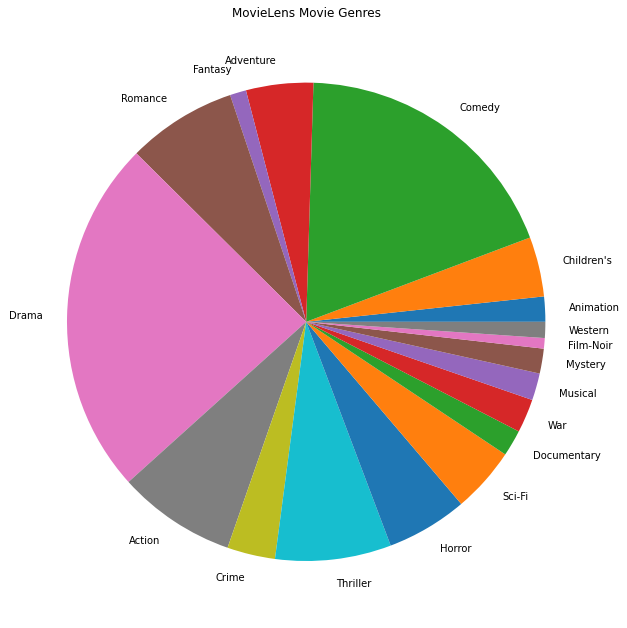

In [9]:
movie_genres_list = movies_df.Genres.tolist()
# Count the number of times each genre describes a movie.
genre_count = collections.defaultdict(int)
for genres in movie_genres_list:
  curr_genres_list = genres.split('|')
  for genre in curr_genres_list:
    genre_count[genre] += 1
genre_name_list, genre_count_list = zip(*genre_count.items())

plt.figure(figsize=(11, 11))
plt.pie(genre_count_list, labels=genre_name_list)
plt.title('MovieLens Movie Genres')
plt.show()

This data is naturally partitioned into ratings from different users, so we'd expect some heterogeneity in data between clients. Below we display the most commonly rated movie genres for different users. We can observe significant differences between users.

In [10]:
def print_top_genres_for_user(ratings_df, movies_df, user_id):
  """Prints top movie genres for user with ID user_id."""
  user_ratings_df = ratings_df[ratings_df.UserID == user_id]
  movie_ids = user_ratings_df.MovieID

  genre_count = collections.Counter()
  for movie_id in movie_ids:
    genres_string = movies_df[movies_df.MovieID == movie_id].Genres.tolist()[0]
    for genre in genres_string.split('|'):
      genre_count[genre] += 1

  print(f'\nFor user {user_id}:')
  for (genre, freq) in genre_count.most_common(5):
    print(f'{genre} was rated {freq} times')

print_top_genres_for_user(ratings_df, movies_df, user_id=0)
print_top_genres_for_user(ratings_df, movies_df, user_id=10)
print_top_genres_for_user(ratings_df, movies_df, user_id=19)


For user 0:
Drama was rated 21 times
Children's was rated 20 times
Animation was rated 18 times
Musical was rated 14 times
Comedy was rated 14 times

For user 10:
Comedy was rated 84 times
Drama was rated 54 times
Romance was rated 22 times
Thriller was rated 18 times
Action was rated 9 times

For user 19:
Action was rated 17 times
Sci-Fi was rated 9 times
Thriller was rated 9 times
Drama was rated 6 times
Crime was rated 5 times


## Preprocessing MovieLens Data

We'll now prepare the MovieLens dataset as a list of `tf.data.Dataset`s representing each user's data for use with TFF.

We implement two functions:
* `create_tf_datasets`: takes our ratings DataFrame and produces a list of user-split `tf.data.Dataset`s.
* `split_tf_datasets`: takes a list of datasets and splits them into train/val/test by *user*, so the val/test sets contain only ratings from users **unseen** during training. Typically in standard centralized matrix factorization we actually split so that the val/test sets contain held-out ratings from **seen** users, since unseen users don't have user embeddings. In our case, we'll see later that the approach we use to enable matrix factorization in FL also enables quickly reconstructing user embeddings for unseen users.

In [11]:
def create_tf_datasets(ratings_df: pd.DataFrame,
                       batch_size: int = 1,
                       max_examples_per_user: Optional[int] = None,
                       max_clients: Optional[int] = None) -> List[tf.data.Dataset]:
  """Creates TF Datasets containing the movies and ratings for all users."""
  num_users = len(set(ratings_df.UserID))
  # Optionally limit to `max_clients` to speed up data loading.
  if max_clients is not None:
    num_users = min(num_users, max_clients)

  def rating_batch_map_fn(rating_batch):
    """Maps a rating batch to an OrderedDict with tensor values."""
    # Each example looks like: {x: movie_id, y: rating}.
    # We won't need the UserID since each client will only look at their own
    # data.
    return collections.OrderedDict([
        ("x", tf.cast(rating_batch[:, 1:2], tf.int64)),
        ("y", tf.cast(rating_batch[:, 2:3], tf.float32))
    ])

  tf_datasets = []
  for user_id in range(num_users):
    # Get subset of ratings_df belonging to a particular user.
    user_ratings_df = ratings_df[ratings_df.UserID == user_id]

    tf_dataset = tf.data.Dataset.from_tensor_slices(user_ratings_df)

    # Define preprocessing operations.
    tf_dataset = tf_dataset.take(max_examples_per_user).shuffle(
        buffer_size=max_examples_per_user, seed=42).batch(batch_size).map(
        rating_batch_map_fn,
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    tf_datasets.append(tf_dataset)

  return tf_datasets


def split_tf_datasets(
    tf_datasets: List[tf.data.Dataset],
    train_fraction: float = 0.8,
    val_fraction: float = 0.1,
) -> Tuple[List[tf.data.Dataset], List[tf.data.Dataset], List[tf.data.Dataset]]:
  """Splits a list of user TF datasets into train/val/test by user.
  """
  np.random.seed(42)
  np.random.shuffle(tf_datasets)

  train_idx = int(len(tf_datasets) * train_fraction)
  val_idx = int(len(tf_datasets) * (train_fraction + val_fraction))

  # Note that the val and test data contains completely different users, not
  # just unseen ratings from train users.
  return (tf_datasets[:train_idx], tf_datasets[train_idx:val_idx],
          tf_datasets[val_idx:])

In [12]:
# We limit the number of clients to speed up dataset creation. Feel free to pass
# max_clients=None to load all clients' data.
tf_datasets = create_tf_datasets(
    ratings_df=ratings_df,
    batch_size=5,
    max_examples_per_user=300,
    max_clients=2000)

# Split the ratings into training/val/test by client.
tf_train_datasets, tf_val_datasets, tf_test_datasets = split_tf_datasets(
    tf_datasets,
    train_fraction=0.8,
    val_fraction=0.1)

As a quick check, we can print a batch of training data. We can see that each individual example contains a MovieID under the "x" key and a rating under the "y" key. Note that we won't need the UserID since each user only sees their own data.

In [13]:
print(next(iter(tf_train_datasets[0])))

OrderedDict([('x', <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[1907],
       [2891],
       [1574],
       [2785],
       [2775]])>), ('y', <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[3.],
       [3.],
       [3.],
       [4.],
       [3.]], dtype=float32)>)])


We can plot a histogram showing the number of ratings per user.

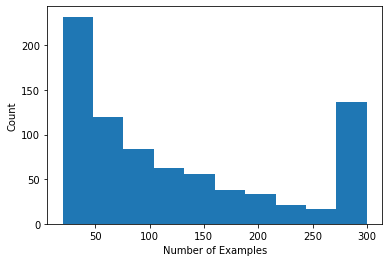

In [14]:
def count_examples(curr_count, batch):
  return curr_count + tf.size(batch['x'])

num_examples_list = []
# Compute number of examples for every other user.
for i in range(0, len(tf_train_datasets), 2):
  num_examples = tf_train_datasets[i].reduce(tf.constant(0), count_examples).numpy()
  num_examples_list.append(num_examples)

plt.hist(num_examples_list, bins=10)
plt.ylabel('Count')
plt.xlabel('Number of Examples')
plt.show()

Now that we've loaded and explored the data, we'll discuss how to bring matrix factorization to federated learning. Along the way, we'll motivate partially local federated learning.

## Bringing Matrix Factorization to FL

While matrix factorization has been traditionally used in centralized settings, it's especially relevant in federated learning:  user ratings may live on separate client devices, and we may want to learn embeddings and recommendations for users and items without centralizing the data. Since each user has a corresponding user embedding, it's natural to have each client store their user embedding–this scales much better than a central server storing all the user embeddings.

One proposal for bringing matrix factorization to FL goes as follows:
1. The server stores and sends the item matrix $I$ to sampled clients each round
2. Clients update the item matrix and their personal user embedding $U_u$ using SGD on the above objective
3. Updates to $I$ are aggregated on the server, updating the server copy of $I$ for the next round

This approach is *partially local*–that is, some client parameters are never aggregated by the server. Though this approach is appealing, it requires clients to maintain state across rounds, namely their user embeddings. Stateful federated algorithms are less appropriate for cross-device FL settings: in these settings the population size is often much larger than the number of clients that participate in each round, and a client usually participates at most once during the training process. Besides relying on state that may not be initialized, stateful algorithms can result in performance degradation in cross-device settings due to state getting *stale* when clients are infrequently sampled. Importantly, in the matrix factorization setting, a stateful algorithm leads to all unseen clients missing trained user embeddings, and in large-scale training the majority of users may be unseen. For more on the motivation for stateless algorithms in cross-device FL, see [Wang et al. 2021 Sec. 3.1.1](https://arxiv.org/pdf/2107.06917.pdf) and [Reddi et al. 2020 Sec. 5.1](https://arxiv.org/abs/2003.00295).

Federated Reconstruction ([Singhal et al. 2021](https://arxiv.org/abs/2102.03448)) is a stateless alternative to the aforementioned approach. The key idea is that instead of storing user embeddings across rounds, clients reconstruct user embeddings when needed. When FedRecon is applied to matrix factorization, training proceeds as follows:
1. The server stores and sends the item matrix $I$ to sampled clients each round
2. Each client freezes $I$ and trains their user embedding $U_u$ using one or more steps of SGD (reconstruction)
3. Each client freezes $U_u$ and trains $I$ using one or more steps of SGD
4. Updates to $I$ are aggregated across users, updating the server copy of $I$ for the next round

This approach does not require clients to maintain state across rounds. The authors also show in the paper that this method leads to fast reconstruction of user embeddings for unseen clients (Sec. 4.2, Fig. 3, and Table 1), allowing the majority of clients who do not participate in training to have a trained model, enabling recommendations for these clients. See the Federated Reconstruction [Google AI Blog post](https://ai.googleblog.com/2021/12/a-scalable-approach-for-partially-local.html) for more key results.

## Defining the Model

We'll next define the local matrix factorization model to be trained on client devices. This model will include the full item matrix $I$ and a single user embedding $U_u$ for client $u$. Note that clients will not need to store the full user matrix $U$.

We'll define the following:
- `UserEmbedding`: a simple Keras layer representing a single `num_latent_factors`-dimensional user embedding.
- `get_matrix_factorization_model`: a function that returns a [`tff.learning.models.ReconstructionModel`](https://www.tensorflow.org/federated/api_docs/python/tff/learning/models/ReconstructionModel) containing the model logic, including which layers are globally aggregated on the server and which layers remain local. We need this additional information to initialize the Federated Reconstruction training process. Here we produce the `tff.learning.models.ReconstructionModel` from a Keras model using [`tff.learning.models.ReconstructionModel.from_keras_model_and_layers`](https://www.tensorflow.org/federated/api_docs/python/tff/learning/models/ReconstructionModel#from_keras_model_and_layers). Similar to `tff.learning.models.VariableModel`, we can also implement a custom `tff.learning.models.ReconstructionModel` by implementing the class interface.

In [15]:
class UserEmbedding(tf.keras.layers.Layer):
  """Keras layer representing an embedding for a single user, used below."""

  def __init__(self, num_latent_factors, **kwargs):
    super().__init__(**kwargs)
    self.num_latent_factors = num_latent_factors

  def build(self, input_shape):
    self.embedding = self.add_weight(
        shape=(1, self.num_latent_factors),
        initializer='uniform',
        dtype=tf.float32,
        name='UserEmbeddingKernel')
    super().build(input_shape)

  def call(self, inputs):
    return self.embedding

  def compute_output_shape(self):
    return (1, self.num_latent_factors)


def get_matrix_factorization_model(
    num_items: int,
    num_latent_factors: int) -> tff.learning.models.ReconstructionModel:
  """Defines a Keras matrix factorization model."""
  # Layers with variables will be partitioned into global and local layers.
  # We'll pass this to `tff.learning.models.ReconstructionModel.from_keras_model_and_layers`.
  global_layers = []
  local_layers = []

  # Extract the item embedding.
  item_input = tf.keras.layers.Input(shape=[1], name='Item')
  item_embedding_layer = tf.keras.layers.Embedding(
      num_items,
      num_latent_factors,
      name='ItemEmbedding')
  global_layers.append(item_embedding_layer)
  flat_item_vec = tf.keras.layers.Flatten(name='FlattenItems')(
      item_embedding_layer(item_input))

  # Extract the user embedding.
  user_embedding_layer = UserEmbedding(
      num_latent_factors,
      name='UserEmbedding')
  local_layers.append(user_embedding_layer)

  # The item_input never gets used by the user embedding layer,
  # but this allows the model to directly use the user embedding.
  flat_user_vec = user_embedding_layer(item_input)

  # Compute the dot product between the user embedding, and the item one.
  pred = tf.keras.layers.Dot(
      1, normalize=False, name='Dot')([flat_user_vec, flat_item_vec])

  input_spec = collections.OrderedDict(
      x=tf.TensorSpec(shape=[None, 1], dtype=tf.int64),
      y=tf.TensorSpec(shape=[None, 1], dtype=tf.float32))

  model = tf.keras.Model(inputs=item_input, outputs=pred)

  return tff.learning.models.ReconstructionModel.from_keras_model_and_layers(
      keras_model=model,
      global_layers=global_layers,
      local_layers=local_layers,
      input_spec=input_spec)

Analagous to the interface for Federated Averaging, the interface for Federated Reconstruction expects a `model_fn` with no arguments that returns a `tff.learning.models.ReconstructionModel`.

In [16]:
# This will be used to produce our training process.
# User and item embeddings will be 50-dimensional.
model_fn = functools.partial(
    get_matrix_factorization_model,
    num_items=3706,
    num_latent_factors=50)

We'll next define `loss_fn` and `metrics_fn`, where `loss_fn` is a no-argument function returning a Keras loss to use to train the model, and `metrics_fn` is a no-argument function returning a list of Keras metrics for evaluation. These are needed to build the training and evaluation computations.

We'll use Mean Squared Error as the loss, as mentioned above. For evaluation we'll use rating accuracy (when the model's predicted dot product is rounded to the nearest whole number, how often does it match the label rating?).

In [17]:
class RatingAccuracy(tf.keras.metrics.Mean):
  """Keras metric computing accuracy of reconstructed ratings."""

  def __init__(self,
               name: str = 'rating_accuracy',
               **kwargs):
    super().__init__(name=name, **kwargs)

  def update_state(self,
                   y_true: tf.Tensor,
                   y_pred: tf.Tensor,
                   sample_weight: Optional[tf.Tensor] = None):
    absolute_diffs = tf.abs(y_true - y_pred)
    # A [batch_size, 1] tf.bool tensor indicating correctness within the
    # threshold for each example in a batch. A 0.5 threshold corresponds
    # to correctness when predictions are rounded to the nearest whole
    # number.
    example_accuracies = tf.less_equal(absolute_diffs, 0.5)
    super().update_state(example_accuracies, sample_weight=sample_weight)


loss_fn = lambda: tf.keras.losses.MeanSquaredError()
metrics_fn = lambda: [RatingAccuracy()]

## Training and Evaluation

Now we have everything we need to define the training process. One important difference from the [interface for Federated Averaging](https://www.tensorflow.org/federated/api_docs/python/tff/learning/algorithms/build_weighted_fed_avg) is that we now pass in a `reconstruction_optimizer_fn`, which will be used when reconstructing local parameters (in our case, user embeddings). It's generally reasonable to use `SGD` here, with a similar or slightly lower learning rate than the client optimizer learning rate. We provide a working configuration below. This hasn't been carefully tuned, so feel free to play around with different values.

Check out the [documentation](https://www.tensorflow.org/federated/api_docs/python/tff/learning/reconstruction/build_training_process) for more details and options.

In [18]:
# We'll use this by doing:
# state = training_process.initialize()
# state, metrics = training_process.next(state, federated_train_data)
training_process = tff.learning.algorithms.build_fed_recon(
    model_fn=model_fn,
    loss_fn=loss_fn,
    metrics_fn=metrics_fn,
    server_optimizer_fn=tff.learning.optimizers.build_sgdm(1.0),
    client_optimizer_fn=tff.learning.optimizers.build_sgdm(0.5),
    reconstruction_optimizer_fn=tff.learning.optimizers.build_sgdm(0.1))

We can also define a computation for evaluating our trained global model.

In [19]:
evaluation_process = tff.learning.algorithms.build_fed_recon_eval(
    model_fn,
    loss_fn=loss_fn,
    metrics_fn=metrics_fn,
    reconstruction_optimizer_fn=tff.learning.optimizers.build_sgdm(0.1))

We can initialize the training process state and examine it. Most importantly, we can see that this server state only stores item variables (currently randomly initialized) and not any user embeddings.

In [22]:
state = training_process.initialize()
model = training_process.get_model_weights(state)
print(model)
print('Item variables shape:', model.trainable[0].shape)

ModelWeights(trainable=[array([[-0.01839826,  0.04044249, -0.04871846, ...,  0.01967763,
        -0.03034571, -0.01698984],
       [-0.03716197,  0.0374358 ,  0.00968184, ..., -0.04857936,
        -0.0385102 , -0.01883975],
       [-0.01227728, -0.04690691,  0.00250578, ...,  0.01141983,
         0.01773251,  0.03525344],
       ...,
       [ 0.03374172,  0.02467764,  0.00621947, ..., -0.01521915,
        -0.01185555,  0.0295455 ],
       [-0.04029766, -0.02826073,  0.0358924 , ..., -0.02519268,
        -0.03909808, -0.01965014],
       [-0.04007702, -0.04353172,  0.04063287, ...,  0.01851353,
        -0.00767929, -0.00816654]], dtype=float32)], non_trainable=[])
Item variables shape: (3706, 50)


We can also try to evaluate our randomly initialized model on validation clients. Federated Reconstruction evaluation here involves the following:

1. The server sends the item matrix $I$ to sampled evaluation clients
2. Each client freezes $I$ and trains their user embedding $U_u$ using one or more steps of SGD (reconstruction)
3. Each client calculates loss and metrics using the server $I$ and reconstructed $U_u$ on an unseen portion of their local data
4. Losses and metrics are averaged across users to calculate overall loss and metrics

Note that steps 1 and 2 are the same as for training. This connection is important, since training the same way we evaluate leads to a form of *meta-learning*, or learning how to learn. In this case, the model is learning how to learn global variables (item matrix) that lead to performant reconstruction of local variables (user embeddings). For more on this, see [Sec. 4.2](https://arxiv.org/abs/2102.03448) of the paper.

It's also important for steps 2 and 3 to be performed using disjoint portions of clients' local data, to ensure fair evaluation. By default, both the training process and evaluation computation use every other example for reconstruction and use the other half post-reconstruction. This behavior can be customized using the `dataset_split_fn` argument (we'll explore this further later).

In [25]:
# We shouldn't expect good evaluation results here, since we haven't trained
# yet!
eval_state = evaluation_process.initialize()
eval_state = evaluation_process.set_model_weights(
  eval_state, training_process.get_model_weights(state)
)
_, eval_metrics = evaluation_process.next(eval_state, tf_val_datasets)
print('Initial Eval:', eval_metrics['client_work']['eval'])

Initial Eval: OrderedDict([('rating_accuracy', 0.0), ('loss', 14.365454)])


We can next try running a round of training. To make things more realistic, we'll sample 50 clients per round randomly without replacement. We should still expect train metrics to be poor, since we're only doing one round of training.

In [26]:
federated_train_data = np.random.choice(tf_train_datasets, size=50, replace=False).tolist()
state, metrics = training_process.next(state, federated_train_data)
print(f'Train metrics:', metrics['client_work']['train'])

Train metrics: OrderedDict([('rating_accuracy', 0.0), ('loss', 14.183293)])


Now let's set up a training loop to train over multiple rounds.

In [28]:
NUM_ROUNDS = 20

train_losses = []
train_accs = []

state = training_process.initialize()

# This may take a couple minutes to run.
for i in range(NUM_ROUNDS):
  federated_train_data = np.random.choice(tf_train_datasets, size=50, replace=False).tolist()
  state, metrics = training_process.next(state, federated_train_data)
  print(f'Train round {i}:', metrics['client_work']['train'])
  train_losses.append(metrics['client_work']['train']['loss'])
  train_accs.append(metrics['client_work']['train']['rating_accuracy'])


eval_state = evaluation_process.set_model_weights(
  eval_state, training_process.get_model_weights(state))
_, eval_metrics = evaluation_process.next(eval_state, tf_val_datasets)
print('Final Eval:', eval_metrics['client_work']['eval'])

Train round 0: OrderedDict([('rating_accuracy', 0.0), ('loss', 14.523704)])
Train round 1: OrderedDict([('rating_accuracy', 0.0), ('loss', 14.552873)])
Train round 2: OrderedDict([('rating_accuracy', 0.0), ('loss', 14.480412)])
Train round 3: OrderedDict([('rating_accuracy', 0.0051107327), ('loss', 12.155375)])
Train round 4: OrderedDict([('rating_accuracy', 0.042440318), ('loss', 9.201913)])
Train round 5: OrderedDict([('rating_accuracy', 0.11840491), ('loss', 5.5969186)])
Train round 6: OrderedDict([('rating_accuracy', 0.12890044), ('loss', 5.5303264)])
Train round 7: OrderedDict([('rating_accuracy', 0.19774501), ('loss', 3.9932375)])
Train round 8: OrderedDict([('rating_accuracy', 0.21234067), ('loss', 3.5070496)])
Train round 9: OrderedDict([('rating_accuracy', 0.21757619), ('loss', 3.5754187)])
Train round 10: OrderedDict([('rating_accuracy', 0.24020319), ('loss', 3.0558898)])
Train round 11: OrderedDict([('rating_accuracy', 0.2337753), ('loss', 3.1659348)])
Train round 12: Ordere

We can plot training loss and accuracy over rounds. The hyperparameters in this notebook have not been carefully tuned, so feel free to try different clients per round, learning rates, number of rounds, and total number of clients to improve these results.

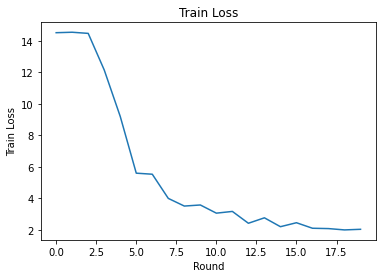

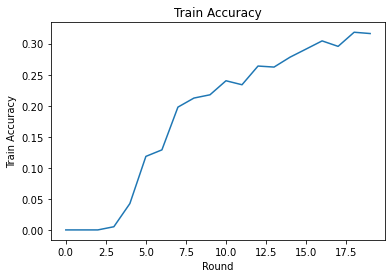

In [29]:
plt.plot(range(NUM_ROUNDS), train_losses)
plt.ylabel('Train Loss')
plt.xlabel('Round')
plt.title('Train Loss')
plt.show()

plt.plot(range(NUM_ROUNDS), train_accs)
plt.ylabel('Train Accuracy')
plt.xlabel('Round')
plt.title('Train Accuracy')
plt.show()

Finally, we can calculate metrics on an unseen test set when we're finished tuning.

In [32]:
eval_state = evaluation_process.set_model_weights(
    eval_state, training_process.get_model_weights(state)
)
_, eval_metrics = evaluation_process.next(eval_state, tf_test_datasets)
print('Final Test:', eval_metrics['client_work']['eval'])

Final Test: OrderedDict([('rating_accuracy', 0.3129535), ('loss', 1.9429641)])


## Further Explorations

Nice work on completing this notebook. We suggest the following exercises to explore partially local federated learning further, roughly ordered by increasing difficulty:

* Typical implementations of Federated Averaging take multiple local passes (epochs) over the data (in addition to taking one pass over the data across multiple batches). For Federated Reconstruction we may want to control the number of steps separately for reconstruction and post-reconstruction training. Passing the `dataset_split_fn` argument to the training and evaluation computation builders enables control of the number of steps and epochs over both reconstruction and post-reconstruction datasets. As an exercise, try performing 3 local epochs of reconstruction training, capped at 50 steps and 1 local epoch of post-reconstruction training, capped at 50 steps. Hint: you'll find [`tff.learning.models.ReconstructionModel.build_dataset_split_fn`](https://www.tensorflow.org/federated/api_docs/python/tff/learning/models/ReconstructionModel#build_dataset_split_fn) helpful. Once you've done this, try tuning these hyperparameters and other related ones like learning rates and batch size to get better results.

* The default behavior of Federated Reconstruction training and evaluation is to split clients' local data in half for each of reconstruction and post-reconstruction. In cases where clients have very little local data, it can be reasonable to reuse data for reconstruction and post-reconstruction for the training process only (not for evaluation, this will lead to unfair evaluation). Try making this change for the training process, ensuring the `dataset_split_fn` for evaluation still keeps reconstruction and post-reconstruction data disjoint. Hint: [`tff.learning.models.ReconstructionModel.simple_dataset_split_fn`](https://www.tensorflow.org/federated/api_docs/python/tff/learning/models/ReconstructionModel#simple_dataset_split_fn) might be useful.

* Above, we produced a `tff.learning.models.VariableModel` from a Keras model using `tff.learning.models.ReconstructionModel.from_keras_model_and_layers`. We can also implement a custom model using pure TensorFlow 2.0 by [implementing the model interface](https://www.tensorflow.org/federated/api_docs/python/tff/learning/models/ReconstructionModel). Try modifying `get_matrix_factorization_model` to build and return a class that extends `tff.learning.models.ReconstructionModel`, implementing its methods. Hint: the source code of [`tff.learning.models.ReconstructionModel.from_keras_model_and_layers`](https://www.tensorflow.org/federated/api_docs/python/tff/learning/models/ReconstructionModel#from_keras_model_and_layers) provides an example of extending the `tff.learning.models.ReconstructionModel` class. Refer also to the [custom model implementation in the EMNIST image classification tutorial](https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification#customizing_the_model_implementation) for a similar exercise in extending a `tff.learning.models.VariableModel`.

* In this tutorial, we've motivated partially local federated learning in the context of matrix factorization, where sending user embeddings to the server would trivially leak user preferences. We can also apply Federated Reconstruction in other settings as a way to train more personal models (since part of the model is completely local to each user) while reducing communication (since local parameters are not sent to the server). In general, using the interface presented here we can take any federated model that would typically be trained fully globally and instead partition its variables into global variables and local variables. The example explored in the [Federated Reconstruction paper](https://arxiv.org/abs/2102.03448) is personal next word prediction: here, each user has their own local set of word embeddings for out-of-vocabulary words, enabling the model to capture users' slang and achieve personalization without additional communication. As an exercise, try implementing (as either a Keras model or a custom TensorFlow 2.0 model) a different model for use with Federated Reconstruction. A suggestion: implement an EMNIST classification model with a personal user embedding, where the personal user embedding is concatenated to the CNN image features before the last Dense layer of the model. You can reuse much of the code from this tutorial (e.g. the `UserEmbedding` class) and the [image classification tutorial](https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification).

\
If you're still looking for more on partially local federated learning, check out the [Federated Reconstruction paper](https://arxiv.org/abs/2102.03448) and [open-source experiment code](https://github.com/google-research/federated/tree/master/reconstruction).